# Description

The main idea is to test the same CNNs that are known to have a good perfomance in medical image segmentation, particularly those that were tested on a retina dataset such as the Drive dataset. Therefore, we use the following machine learning algorithms to segment the vessels from our egg datasets:

- U-net: This model was based in the paper [U-Net: Convolutional Networks for Biomedical](https://arxiv.org/pdf/1505.04597.pdf).

- M2V-net: This model was prepared using a pretrained layers of [MobileNetV2](https://arxiv.org/pdf/1801.04381.pdf) as the enconder, and for the decoder it was used a upsample block implemented in pix2pix. The complete description of this model can be found as an example in [Tensorflow site](https://www.tensorflow.org/tutorials/images/segmentation).

- M2U-net: This model was based in this [paper](https://arxiv.org/pdf/1811.07738.pdf), some of the layers are based in the MobileNetV2.

This project is a work in progress, it is still necessary to get better dataset labels, obfuscate the image background before taking a picture and define a good metric to measure how good the segmentation is. In particular, the metric should be adapted to improve the accuracy of any requested laboratorial measurements.

> We tried to use only TensorFlow or Numpy functions, since the model will be faster and easier to deploy using other TensorFlow APIs.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_io as tfio
from IPython import display
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

from sklearn.metrics import jaccard_score, f1_score, confusion_matrix, \
                            roc_curve, roc_auc_score

In [2]:
print(tf.__version__)

2.7.0


# U-net model


## Dataset Parameters

In [3]:
# Images parameters
channels = 3
height = 1532
width = 2048

# Resize parameters
resize_h = height + 4
crop_wh = 128

In [4]:
# File paths
path = "./eggs/"

In [5]:
image_paths = [path + str(i) + '.jpg' for i in range(1, 5)]
label_paths= [path + 'bin-seg-' + str(i) + '.jpg' for i in range(1, 5)]

In [6]:
# Number of cuts in an image
(height + 4) // crop_wh, width // crop_wh

(12, 16)

## Construct the train dataset

In [7]:
shuffle_buffer = len(image_paths) * (resize_h // crop_wh) * (width // crop_wh)
batch_size = 16

print('Shuffle buffer size: {}'.format(shuffle_buffer))

Shuffle buffer size: 768


In [8]:
def load(image_paths, label_paths):
    
    image_string = tf.io.read_file(image_paths)
    label_string = tf.io.read_file(label_paths)
    
    image = tf.io.decode_jpeg(image_string, channels=3)
    
    label = tf.io.decode_jpeg(label_string, channels=0)  
    label = tf.image.rgb_to_grayscale(label)
    
    image = tf.cast(image, dtype=tf.float32)
    label = tf.cast(label, dtype=tf.float32)
    
    image.set_shape((height, width, channels))
    label.set_shape((height, width, 1))

    return image, label

In [9]:
def augment(image, label):

    ran = tf.random.uniform([2], minval=1 - 0.3, maxval=1 + 0.3)

    image = tf.image.adjust_brightness(image, ran[0])
    image = tf.image.adjust_contrast(image, ran[1])
    
    ran = tf.random.uniform([2], minval=1 - 0.02, maxval=1 + 0.02)

    image = tf.image.adjust_saturation(image, ran[0])
    image = tf.image.adjust_hue(image, ran[1])

    image = rgb2gray(image)
    image_shape = image.shape
    label_shape = label.shape

    image = tf.py_function(clahe_equalized, [image], tf.uint8)
    image.set_shape(image_shape)

    image = tf.image.resize(image, [resize_h, width], method='nearest')
    label = tf.image.resize(label, [resize_h, width], method='nearest')

    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.image.convert_image_dtype(label, tf.float32) / 255

    image, label = crop(image, label, crop_wh, image.shape[-1])

    return image, label

In [10]:
class random_flip_rot(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.flip_inputs = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
    self.flip_labels = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
    self.rot_inputs = tf.keras.layers.RandomRotation(0.15, seed=seed, interpolation='nearest')
    self.rot_labels = tf.keras.layers.RandomRotation(0.15, seed=seed, interpolation='nearest')

  def call(self, inputs, labels):
    
    ran = tf.random.uniform([2], maxval=1)

    if ran[0] < 0.5:
      inputs = self.flip_inputs(inputs)
      labels = self.flip_labels(labels)

    if ran[1] < 0.5:
      inputs = self.rot_inputs(inputs)
      labels = self.rot_labels(labels)

    return inputs, labels

In [11]:
def clahe_equalized(image):

    image = image.numpy()

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image = clahe.apply(image.astype(np.uint8))

    return np.expand_dims(image, axis=-1)

In [12]:
def random_flip(image, labels):
  
  '''does a random flip of the image and mask'''

  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    labels = tf.image.flip_left_right(labels)

  return image, labels

@tf.function
def rgb2gray(image):
    gray_scale = image[:,:,0]*0.299 + image[:,:,1]*0.587 + image[:,:,2]*0.114
    return tf.expand_dims(gray_scale, axis=-1)

In [13]:
def crop(image, label, cut_size, image_channels):

  """Returns a cropped square image."""
  
  shape = image.shape

  image_new = tf.zeros((0, cut_size, cut_size, image_channels))
  label_new = tf.zeros((0, cut_size, cut_size, 1))


  for idx in range(0, shape[1] // cut_size):
    for idy in range(0, shape[0] // cut_size):

      image_aux = tf.expand_dims(tf.image.crop_to_bounding_box(
          image, idy * cut_size, idx * cut_size, cut_size, cut_size), axis=0)
      label_aux = tf.expand_dims(tf.image.crop_to_bounding_box(
          label, idy * cut_size, idx * cut_size, cut_size, cut_size), axis=0)
    
      image_new = tf.concat([image_new, image_aux], axis=0)
      label_new = tf.concat([label_new, label_aux], axis=0)

  return image_new, label_new

In [14]:
def split_dataset(dataset: tf.data.Dataset, validation_data_fraction: float):
    """
    Splits a dataset of type tf.data.Dataset into a training and validation dataset using given ratio. Fractions are
    rounded up to two decimal places.
    @param dataset: the input dataset to split.
    @param validation_data_fraction: the fraction of the validation data as a float between 0 and 1.
    @return: a tuple of two tf.data.Datasets as (training, validation)
    """

    validation_data_percent = round(validation_data_fraction * 100)
    if not (0 <= validation_data_percent <= 100):
        raise ValueError("validation data fraction must be ∈ [0,1]")

    dataset = dataset.enumerate()
    train_dataset = dataset.filter(lambda f, data: f % 100 > validation_data_percent)
    validation_dataset = dataset.filter(lambda f, data: f % 100 <= validation_data_percent)

    # remove enumeration
    train_dataset = train_dataset.map(lambda f, data: data)
    validation_dataset = validation_dataset.map(lambda f, data: data)

    return train_dataset, validation_dataset

In [15]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

dataset = dataset.map(load)
dataset = dataset.map(augment)
dataset = dataset.map(random_flip_rot())

dataset = dataset.flat_map(
    lambda image, label: tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(image), 
    tf.data.Dataset.from_tensor_slices(label))
    ))

train_dataset, val_dataset = split_dataset(dataset, 0.1)

train_dataset = train_dataset.shuffle(shuffle_buffer)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

del(dataset)

In [16]:
train_dataset, val_dataset

(<PrefetchDataset shapes: ((None, 128, 128, 1), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 128, 128, 1), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>)

## Define U-net model

In [17]:
from tensorflow.keras.layers import Input, concatenate, BatchNormalization, \
                                    Conv2D, MaxPooling2D, MaxPool2D, \
                                    UpSampling2D, Reshape, Dropout, Reshape, \
                                    Permute, Activation, Conv2DTranspose,  \
                                    Concatenate

In [18]:
save_path = 'my_Unet_Eggs.h5'
save_best_only = True

### Auxiliary functions for the model

In [19]:
def conv2d_block(input, n_filters, kernel_size = 3, activation='relu'):

  x = input

  for i in range(2):
    x = Conv2D(filters=n_filters,
                               kernel_size=(kernel_size, kernel_size),
                               activation=None,
                               padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

  return x

def one_encoder_block(input, n_filters):

  f = conv2d_block(input, n_filters)
  x = MaxPool2D(pool_size=(2, 2))(f)

  return f, x

def one_decoder_block(inputs, decoder_output, n_filters, kernel_size = 3):

  f = Conv2DTranspose(filters=n_filters,
                                      kernel_size=(kernel_size, kernel_size),
                                      padding = 'same',
                                      strides= (2, 2))(inputs)

  f = Concatenate()([f, decoder_output])
  f = conv2d_block(f, n_filters, kernel_size=3)

  return f

## Build U-net

- Build U-net with input (crop_hw, crop_hw, 1)

In [20]:
def encoder(inputs):

  f1, x = one_encoder_block(inputs, 32) 
  f2, x = one_encoder_block(x, 64) 
  f3, x = one_encoder_block(x, 128) 

  return x, (f1, f2, f3)

def bottle_neck(input, n_filters=256):
  
  f = conv2d_block(input, n_filters)

  return f

def decoder(inputs, encoder_outputs, n_labels):

  f1, f2, f3 = encoder_outputs

  x = one_decoder_block(inputs, f3, n_filters=128, kernel_size = 3)
  x = one_decoder_block(x, f2, n_filters=64, kernel_size = 3)
  x = one_decoder_block(x, f1, n_filters=32, kernel_size = 3)

  outputs = Conv2D(n_labels, (1, 1), activation='sigmoid')(x)

  return outputs

In [21]:
def build_unet(patch_height, patch_width, n_ch):

  input = Input(shape=(patch_height, patch_width, n_ch))

  x, encoder_outputs = encoder(input)
  
  bottleneck = bottle_neck(x)

  output = decoder(bottleneck, encoder_outputs, 1)

  model = Model(inputs=input, outputs=output)

  return model

In [22]:
model = build_unet(crop_wh, crop_wh, 1)

## Callbacks

### Dice and Jaccard functions

In [23]:
def jaccard(y_true, y_pred):

  intersection = tf.reduce_sum(y_true * y_pred)
  sum_ = tf.reduce_sum(y_true + y_pred)
  jac = (intersection) / (sum_ - intersection)
    
  return jac

In [24]:
def dice(y_true, y_pred):
    
  y_true = tf.cast(y_true, tf.float32)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return numerator / denominator

### Callbacks

In [25]:
checkpointer = ModelCheckpoint(save_path,
                               verbose=1, monitor='val_loss', mode='auto',
                               save_best_only=save_best_only)

class CustomCallback(tf.keras.callbacks.Callback):

  def __init__(self, model, dataset, display_freq=9):

    self.model = model
    self.dataset = dataset
    self.display_freq = display_freq

  def on_epoch_end(self, epoch, logs=None):

    if epoch % self.display_freq == 0:
    
      display.clear_output(wait=True)
    
      plt.figure(figsize=(10, 10))
        
      for data in self.dataset.take(1):

          image = data[0].numpy()
          label = data[1].numpy()

          pred = self.model.predict(image)

          print(' ')
          
          jac = jaccard(data[1], tf.convert_to_tensor(pred)).numpy()
          dic = dice(data[1], tf.convert_to_tensor(pred)).numpy()

          print('jaccard: {:2.2f}'.format(jac))
          print('dice: {:2.2f}'.format(dic))

          print(' ')

          #pred[pred < 0.5] = 0
          #pred[pred >= 0.5] = 1

          ax = plt.subplot(2, 2, 1)
            
          plot = cv2.cvtColor(label[0, ...].astype('float32'), cv2.IMREAD_COLOR)

          plt.imshow(plot)
          plt.title('True')
          plt.axis('off')
          
          ax = plt.subplot(2, 2, 2)
            
          plot = cv2.cvtColor(pred[0, ...].astype('float32'), cv2.IMREAD_COLOR)

          plt.imshow(plot)
          plt.title('Predicted')
          plt.axis('off')

      plt.show()
    
      auc = []

      for data in self.dataset:
            
          pred = self.model.predict(data[0])
          label = data[1].numpy()
        
          label[label > 0.5] = 1
          label[label <= 0.5] = 0

          auc.append(roc_auc_score(label.reshape(-1), pred.reshape(-1)))

      auc = np.asarray(auc)

      print(' ')
      print('auc: {:2.2f}'.format(np.mean(auc), np.std(auc)))
      print(' ')

## Compile and show the model architecture

In [26]:
def combined_loss(y_true, y_pred):

  intersection = tf.reduce_sum(y_true * y_pred)
  sum_ = tf.reduce_sum(y_true + y_pred)
  jac = (intersection) / (sum_ - intersection)

  jac = (1 - jac)

  loss = (tf.keras.losses.binary_crossentropy(y_true, y_pred) +
        0.3 * jac)

  return loss

In [27]:
model.compile(optimizer='adam', loss=combined_loss, 
              metrics=['accuracy', jaccard, dice])

In [ ]:
model.summary()

## Train

 
jaccard: 0.51
dice: 0.68
 


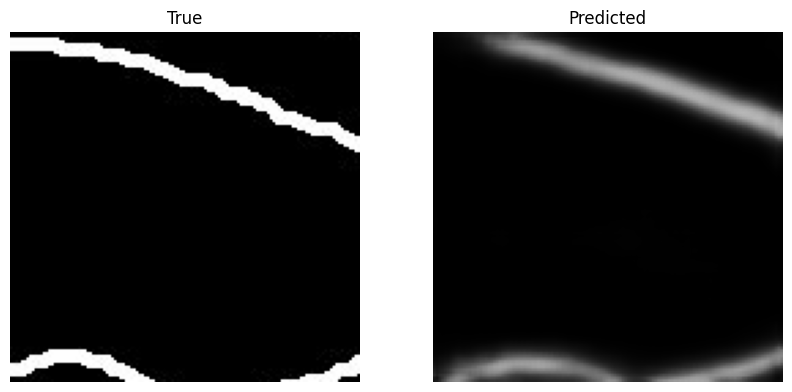

 
auc: 0.95
 
22/22 - 34s - loss: 0.3238 - accuracy: 0.8422 - jaccard: 0.4512 - dice: 0.6190 - val_loss: 0.3788 - val_accuracy: 0.8280 - val_jaccard: 0.4181 - val_dice: 0.5871 - 34s/epoch - 2s/step
Epoch 299/300

Epoch 00299: val_loss did not improve from 0.34819
22/22 - 18s - loss: 0.3160 - accuracy: 0.8437 - jaccard: 0.4661 - dice: 0.6329 - val_loss: 0.3660 - val_accuracy: 0.8288 - val_jaccard: 0.4414 - val_dice: 0.6115 - 18s/epoch - 797ms/step
Epoch 300/300

Epoch 00300: val_loss did not improve from 0.34819
22/22 - 19s - loss: 0.3118 - accuracy: 0.8450 - jaccard: 0.4678 - dice: 0.6361 - val_loss: 0.3706 - val_accuracy: 0.8296 - val_jaccard: 0.4430 - val_dice: 0.6131 - 19s/epoch - 872ms/step


In [28]:
history = model.fit(train_dataset, epochs=300, verbose=2, 
                    callbacks=[checkpointer, CustomCallback(model, train_dataset)],
                    validation_data=val_dataset)

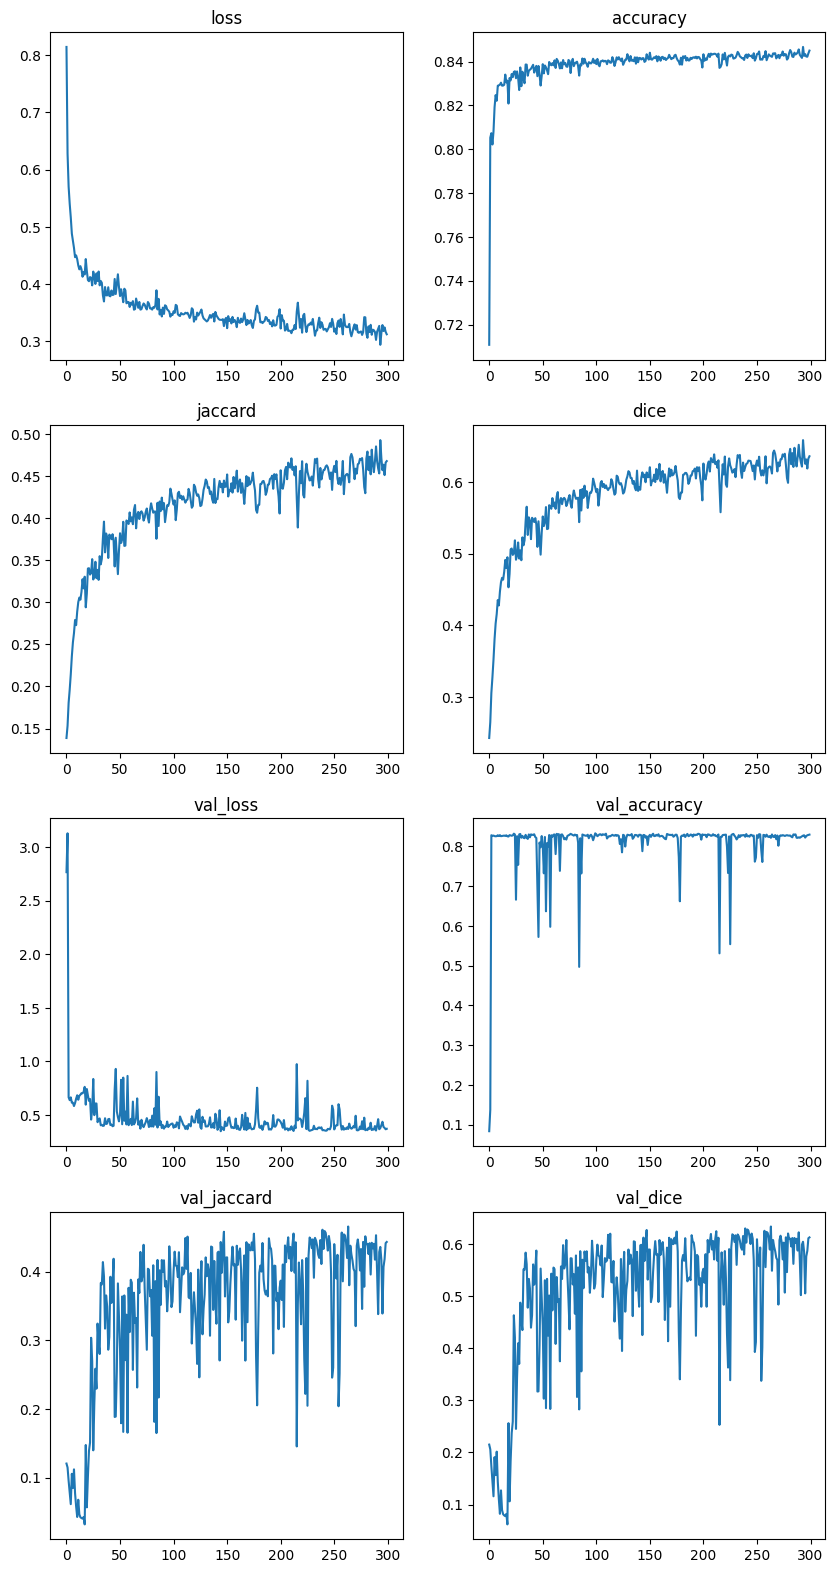

In [29]:
plt.figure(figsize=(10, 40))

for idx, key in enumerate(history.history.keys()):
    
    ax = plt.subplot(8, 2, 1 + idx)
    plt.title(key)
    plt.plot(history.history[key])

plt.show()

## Compare the results with the test images


### Get the test dataset and evaluate the model in it.

In [30]:
# The test batch size is equal to the number of pieces cut from the original
# image, this was done so that we can reconstruct the image later.

test_batch = (resize_h // crop_wh) * (width // crop_wh)

In [31]:
def parse_function_test(image, label):

    image = rgb2gray(image)
    image_shape = image.shape
    label_shape = label.shape

    image = tf.py_function(clahe_equalized, [image], tf.uint8)
    image.set_shape(image_shape)

    image = tf.image.resize(image, [resize_h, width], method='nearest')
    label = tf.image.resize(label, [resize_h, width], method='nearest')

    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.image.convert_image_dtype(label, tf.float32) / 255

    image, label = crop(image, label, crop_wh, image.shape[-1])

    return image, label

In [32]:
test_file_names = [path + str(i) + '.jpg' for i in range(5, 6)]
test_labels = [path + 'bin-seg-' + str(i) + '.jpg' for i in range(5, 6)]

test_dataset = tf.data.Dataset.from_tensor_slices((test_file_names, test_labels))

test_dataset = test_dataset.map(load)
test_dataset = test_dataset.map(parse_function_test)

test_dataset = test_dataset.flat_map(
    lambda image, label: tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(image), 
    tf.data.Dataset.from_tensor_slices(label))
    ))

test_dataset = test_dataset.batch(test_batch).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [33]:
_ = model.evaluate(test_dataset)

1/1 [==============================] - 13s 13s/step - loss: 0.3674 - accuracy: 0.8579 - jaccard: 0.3874 - dice: 0.5584


### Predict and plot the segmented images

- White: Ground Truth.
- Blue: True Positive.
- Green: False Positive.

In [34]:
# pred = model.predict(test_dataset)

In [35]:
def rebuild_image(image_cropped, label_cropped, image_pred_cropped):
    
    image = np.ones((resize_h, width, 1))
    label = np.ones((resize_h, width, 1))
    image_pred = np.ones((resize_h, width, 1))

    cont = 0

    for idx in range(0, image.shape[1] // crop_wh):
        for idy in range(0, image.shape[0] // crop_wh):
          
          image[idy * crop_wh: (idy + 1) * crop_wh, idx * crop_wh: (idx + 1) * crop_wh, :] = image_cropped[cont, ...]
          label[idy * crop_wh: (idy + 1) * crop_wh, idx * crop_wh: (idx + 1) * crop_wh, :] = label_cropped[cont, ...]
          image_pred[idy * crop_wh: (idy + 1) * crop_wh, idx * crop_wh: (idx + 1) * crop_wh, :] = image_pred_cropped[cont, ...]
          cont += 1

    return image, label, image_pred

In [36]:
def color_labels(label, image_pred):

    color_label = np.zeros((resize_h, width, 3))

    i_t, j_t = np.where(label[..., 0] > 0.1)

    # Color with white pixels where labels are equal to one.
    color_label[i_t, j_t, :] = 255
    
    i, j = np.where(image_pred[..., 0] > 0.5)
    
    label_set = set([(a, b) for a, b in zip(i_t, j_t)])
    pred_set = set([(a, b) for a, b in zip(i, j)])
    pred_tp = set(label_set).intersection(pred_set)
    
    pred_fp = pred_set - pred_tp

    k1, k2 = zip(*pred_tp)
    color_label[k1, k2, 0:2] = 0

    k1, k2 = zip(*pred_fp)
    color_label[k1, k2, 1:2] = 255

    return color_label 

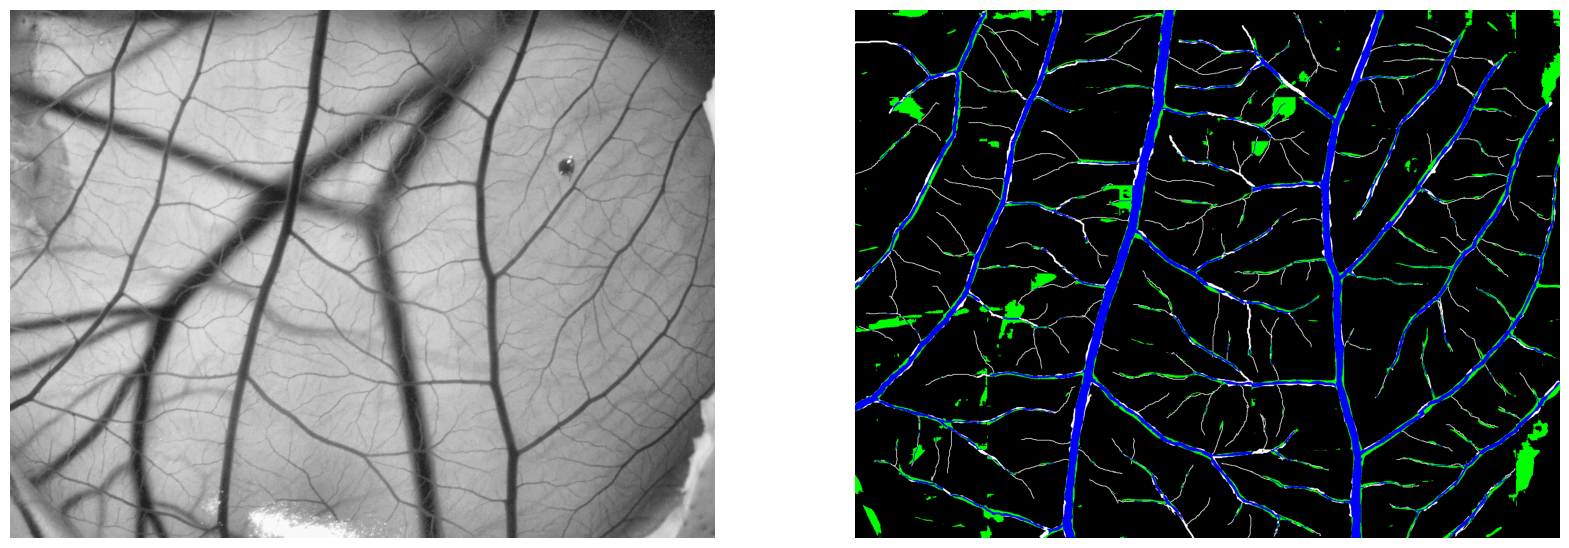

In [37]:
for data in test_dataset:
  
  image_cropped = data[0].numpy()
  label_cropped = data[1].numpy()

  image_pred_cropped = model.predict(image_cropped)

  image, label, image_pred = rebuild_image(image_cropped,
                                           label_cropped,
                                           image_pred_cropped)
  label = color_labels(label, image_pred)
  
  
  plt.figure(figsize=(20, 20))
  ax = plt.subplot(1, 2, 1)
  image = cv2.cvtColor(image.astype('float32'), cv2.IMREAD_COLOR)
 
  plt.imshow(image)
  plt.axis('off')
  
  ax = plt.subplot(1, 2, 2)
  pred_label = cv2.cvtColor(label.astype('uint8'), cv2.IMREAD_COLOR)

  plt.imshow(pred_label)
  plt.axis('off')
  plt.show()
  

# MobilineNetV2 - Transfer Learning

## Dataset Parameters

In [ ]:
# Images parameters
channels = 3
height = 1532
width = 2048

# Resize parameters
resize_h = height + 4
crop_wh = 128

In [ ]:
# File paths
path = "./eggs/"

In [ ]:
image_paths = [path + str(i) + '.jpg' for i in range(1, 5)]
label_paths= [path + 'bin-seg-' + str(i) + '.jpg' for i in range(1, 5)]

In [ ]:
# Number of cuts in an image
(height + 4) // crop_wh, width // crop_wh

## Construct the train dataset

In [ ]:
shuffle_buffer = len(image_paths) * (resize_h // crop_wh) * (width // crop_wh)
batch_size = 16

print('Shuffle buffer size: {}'.format(shuffle_buffer))

In [ ]:
def load(image_paths, label_paths):
    
    image_string = tf.io.read_file(image_paths)
    label_string = tf.io.read_file(label_paths)
    
    image = tf.io.decode_jpeg(image_string, channels=3)
    
    label = tf.io.decode_jpeg(label_string, channels=0)  
    label = tf.image.rgb_to_grayscale(label)
    
    image = tf.cast(image, dtype=tf.float32)
    label = tf.cast(label, dtype=tf.float32)
    
    image.set_shape((height, width, channels))
    label.set_shape((height, width, 1))

    return image, label

In [ ]:
def augment(image, label):

    image = image[..., :3]
    image_shape = image.shape
    label_shape = label.shape

    ran = tf.random.uniform([2], minval=1 - 0.3, maxval=1 + 0.3)

    image = tf.image.adjust_brightness(image, ran[0])
    image = tf.image.adjust_contrast(image, ran[1])
    
    ran = tf.random.uniform([2], minval=1 - 0.02, maxval=1 + 0.02)

    image = tf.image.adjust_saturation(image, ran[0])
    image = tf.image.adjust_hue(image, ran[1])

    image = tf.image.resize(image, [resize_h, width], method='nearest')
    label = tf.image.resize(label, [resize_h, width], method='nearest')

    image = tf.image.convert_image_dtype(image, tf.float32) / 255
    label = tf.image.convert_image_dtype(label, tf.float32) / 255

    #image, label = random_flip(image, label)

    image, label = crop(image, label, crop_wh, image.shape[-1])

    return image, label

In [ ]:
class random_flip_rot(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.flip_inputs = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
    self.flip_labels = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
    self.rot_inputs = tf.keras.layers.RandomRotation(0.15, seed=seed, interpolation='nearest')
    self.rot_labels = tf.keras.layers.RandomRotation(0.15, seed=seed, interpolation='nearest')

  def call(self, inputs, labels):
    
    ran = tf.random.uniform([2], maxval=1)

    if ran[0] < 0.5:
      inputs = self.flip_inputs(inputs)
      labels = self.flip_labels(labels)

    if ran[1] < 0.5:
      inputs = self.rot_inputs(inputs)
      labels = self.rot_labels(labels)

    return inputs, labels

In [ ]:
def clahe_equalized(image):

    image = image.numpy()

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image = clahe.apply(image.astype(np.uint8))

    return np.expand_dims(image, axis=-1)

In [ ]:
def crop(image, label, cut_size, image_channels):

  """Returns a cropped square image."""
  
  shape = image.shape

  image_new = tf.zeros((0, cut_size, cut_size, image_channels))
  label_new = tf.zeros((0, cut_size, cut_size, 1))


  for idx in range(0, shape[1] // cut_size):
    for idy in range(0, shape[0] // cut_size):

      image_aux = tf.expand_dims(tf.image.crop_to_bounding_box(
          image, idy * cut_size, idx * cut_size, cut_size, cut_size), axis=0)
      label_aux = tf.expand_dims(tf.image.crop_to_bounding_box(
          label, idy * cut_size, idx * cut_size, cut_size, cut_size), axis=0)
    
      image_new = tf.concat([image_new, image_aux], axis=0)
      label_new = tf.concat([label_new, label_aux], axis=0)

  return image_new, label_new

In [ ]:
def split_dataset(dataset: tf.data.Dataset, validation_data_fraction: float):
    """
    Splits a dataset of type tf.data.Dataset into a training and validation dataset using given ratio. Fractions are
    rounded up to two decimal places.
    @param dataset: the input dataset to split.
    @param validation_data_fraction: the fraction of the validation data as a float between 0 and 1.
    @return: a tuple of two tf.data.Datasets as (training, validation)
    """

    validation_data_percent = round(validation_data_fraction * 100)
    if not (0 <= validation_data_percent <= 100):
        raise ValueError("validation data fraction must be ∈ [0,1]")

    dataset = dataset.enumerate()
    train_dataset = dataset.filter(lambda f, data: f % 100 > validation_data_percent)
    validation_dataset = dataset.filter(lambda f, data: f % 100 <= validation_data_percent)

    # remove enumeration
    train_dataset = train_dataset.map(lambda f, data: data)
    validation_dataset = validation_dataset.map(lambda f, data: data)

    return train_dataset, validation_dataset

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

dataset = dataset.map(load)
dataset = dataset.map(augment)
dataset = dataset.map(random_flip_rot())

dataset = dataset.flat_map(
    lambda image, label: tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(image), 
    tf.data.Dataset.from_tensor_slices(label))
    ))

train_dataset, val_dataset = split_dataset(dataset, 0.1)

train_dataset = train_dataset.shuffle(shuffle_buffer)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

del(dataset)

In [ ]:
train_dataset, val_dataset

## Define M2V-net model

In [ ]:
from tensorflow.keras.layers import Input, concatenate, BatchNormalization, \
                                    Conv2D, MaxPooling2D, MaxPool2D, \
                                    UpSampling2D, Reshape, Dropout, Reshape, \
                                    Permute, Activation, Conv2DTranspose,  \
                                    Concatenate

In [ ]:
save_path = 'my_M2Vnet_Eggs.h5'
save_best_only = True

In [ ]:
pip install -q git+https://github.com/tensorflow/examples.git

### Auxiliary functions for the model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[crop_wh, crop_wh, 3], include_top=False)

In [ ]:
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Crie o modelo de extração de características
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

## Build M2V-net

- Build U-net with input (crop_hw, crop_hw, 3)

In [ ]:
def unet_model(output_channels):

  # Esta é a última camada do modelo
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='sigmoid')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling através do modelo
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling e estabelecimento das conexões de salto
  
  for i, (up, skip) in enumerate(zip(up_stack, skips)):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(1)

## Callbacks

### Dice and Jaccard functions

In [ ]:
def jaccard(y_true, y_pred):

  intersection = tf.reduce_sum(y_true * y_pred)
  sum_ = tf.reduce_sum(y_true + y_pred)
  jac = (intersection) / (sum_ - intersection)
    
  return jac

In [ ]:
def dice(y_true, y_pred):
    
  y_true = tf.cast(y_true, tf.float32)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return numerator / denominator

### Callbacks

In [ ]:
checkpointer = ModelCheckpoint(save_path,
                               verbose=1, monitor='val_loss', mode='auto',
                               save_best_only=save_best_only)

class CustomCallback(tf.keras.callbacks.Callback):

  def __init__(self, model, dataset, display_freq=9):

    self.model = model
    self.dataset = dataset
    self.display_freq = display_freq

  def on_epoch_end(self, epoch, logs=None):

    if epoch % self.display_freq == 0:
      
      display.clear_output(wait=True)
    
      plt.figure(figsize=(10, 10))
        
      for data in self.dataset.take(1):

          image = data[0].numpy()
          label = data[1].numpy()

          pred = self.model.predict(image)

          print(' ')
          
          jac = jaccard(data[1], tf.convert_to_tensor(pred)).numpy()
          dic = dice(data[1], tf.convert_to_tensor(pred)).numpy()

          print('jaccard: {:2.2f}'.format(jac))
          print('dice: {:2.2f}'.format(dic))

          print(' ')

          #pred[pred < 0.5] = 0
          #pred[pred >= 0.5] = 1

          ax = plt.subplot(2, 2, 1)
            
          plot = cv2.cvtColor(label[0, ...].astype('float32'), cv2.IMREAD_COLOR)

          plt.imshow(plot)
          plt.title('True')
          plt.axis('off')
          
          ax = plt.subplot(2, 2, 2)
            
          plot = cv2.cvtColor(pred[0, ...].astype('float32'), cv2.IMREAD_COLOR)

          plt.imshow(plot)
          plt.title('Predicted')
          plt.axis('off')

      plt.show()
    
      auc = []

      for data in self.dataset:
            
          pred = self.model.predict(data[0])
          label = data[1].numpy()
        
          label[label > 0.5] = 1
          label[label <= 0.5] = 0

          auc.append(roc_auc_score(label.reshape(-1), pred.reshape(-1)))

      auc = np.asarray(auc)

      print(' ')
      print('auc: {:2.2f}'.format(np.mean(auc), np.std(auc)))
      print(' ')

## Compile and show the model architecture

In [ ]:
def combined_loss(y_true, y_pred):

  intersection = tf.reduce_sum(y_true * y_pred)
  sum_ = tf.reduce_sum(y_true + y_pred)
  jac = (intersection) / (sum_ - intersection)

  jac = (1 - jac)

  loss = (tf.keras.losses.binary_crossentropy(y_true, y_pred) +
        0.3 * jac)

  return loss

In [ ]:
model.compile(optimizer='adam', loss=combined_loss, 
              metrics=['accuracy', jaccard, dice])

In [ ]:
model.summary()

## Train

In [ ]:
history = model.fit(train_dataset, epochs=300, verbose=2, 
                    callbacks=[checkpointer, CustomCallback(model, train_dataset)],
                    validation_data=val_dataset)

In [ ]:
plt.figure(figsize=(10, 40))

for idx, key in enumerate(history.history.keys()):
    
    ax = plt.subplot(8, 2, 1 + idx)
    plt.title(key)
    plt.plot(history.history[key])

plt.show()

## Compare the results with the test images


### Get the test dataset and evaluate the model in it.

In [ ]:
# The test batch size is equal to the number of pieces cut from the original
# image, this was done so that we can reconstruct the image later.

test_batch = (resize_h // crop_wh) * (width // crop_wh)

In [ ]:
def parse_function_test(image, label):

    image = image[..., :3]
    image_shape = image.shape
    label_shape = label.shape

    image = tf.image.resize(image, [resize_h, width], method='nearest')
    label = tf.image.resize(label, [resize_h, width], method='nearest')

    image = tf.image.convert_image_dtype(image, tf.float32) / 255
    label = tf.image.convert_image_dtype(label, tf.float32) / 255

    image, label = crop(image, label, crop_wh, image.shape[-1])

    return image, label

In [ ]:
test_file_names = [path + str(i) + '.jpg' for i in range(5, 6)]
test_labels = [path + 'bin-seg-' + str(i) + '.jpg' for i in range(5, 6)]

test_dataset = tf.data.Dataset.from_tensor_slices((test_file_names, test_labels))

test_dataset = test_dataset.map(load)
test_dataset = test_dataset.map(parse_function_test)

test_dataset = test_dataset.flat_map(
    lambda image, label: tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(image), 
    tf.data.Dataset.from_tensor_slices(label))
    ))

test_dataset = test_dataset.batch(test_batch).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
_ = model.evaluate(test_dataset)

### Predict and plot the segmented images

- White: Ground Truth.
- Blue: True Positive.
- Green: False Positive.

In [ ]:
# pred = model.predict(test_dataset)

In [ ]:
def rebuild_image(image_cropped, label_cropped, image_pred_cropped):
    
    image = np.ones((resize_h, width, 3))
    label = np.ones((resize_h, width, 1))
    image_pred = np.ones((resize_h, width, 1))

    cont = 0

    for idx in range(0, image.shape[1] // crop_wh):
        for idy in range(0, image.shape[0] // crop_wh):
          
          image[idy * crop_wh: (idy + 1) * crop_wh, idx * crop_wh: (idx + 1) * crop_wh, :] = image_cropped[cont, ...]
          label[idy * crop_wh: (idy + 1) * crop_wh, idx * crop_wh: (idx + 1) * crop_wh, :] = label_cropped[cont, ...]
          image_pred[idy * crop_wh: (idy + 1) * crop_wh, idx * crop_wh: (idx + 1) * crop_wh, :] = image_pred_cropped[cont, ...]
          cont += 1

    return image, label, image_pred

In [ ]:
def color_labels(label, image_pred):

    color_label = np.zeros((resize_h, width, 3))

    i_t, j_t = np.where(label[..., 0] > 0.1)

    # Color with white pixels where labels are equal to one.
    color_label[i_t, j_t, :] = 255
    
    i, j = np.where(image_pred[..., 0] > 0.5)
    
    label_set = set([(a, b) for a, b in zip(i_t, j_t)])
    pred_set = set([(a, b) for a, b in zip(i, j)])
    pred_tp = set(label_set).intersection(pred_set)
    
    pred_fp = pred_set - pred_tp

    k1, k2 = zip(*pred_tp)
    color_label[k1, k2, 0:2] = 0

    k1, k2 = zip(*pred_fp)
    color_label[k1, k2, 1:2] = 255

    return color_label 

In [ ]:
for data in test_dataset:
  
  image_cropped = data[0].numpy()
  label_cropped = data[1].numpy()

  image_pred_cropped = model.predict(image_cropped)

  image, label, image_pred = rebuild_image(image_cropped,
                                           label_cropped,
                                           image_pred_cropped)
  label = color_labels(label, image_pred)
  
  
  plt.figure(figsize=(20, 20))
  ax = plt.subplot(1, 2, 1)
  image = cv2.cvtColor(image.astype('float32'), cv2.IMREAD_COLOR)
 
  plt.imshow(image)
  plt.axis('off')
  
  ax = plt.subplot(1, 2, 2)
  pred_label = cv2.cvtColor(label.astype('uint8'), cv2.IMREAD_COLOR)

  plt.imshow(pred_label)
  plt.axis('off')
  plt.show()

# M2U-net

## Dataset Parameters

In [3]:
# Images parameters
channels = 3
height = 1532
width = 2048

# Resize parameters
resize_h = height + 4
crop_wh = 128

In [4]:
# File paths
path = "./eggs/"

In [5]:
image_paths = [path + str(i) + '.jpg' for i in range(1, 5)]
label_paths= [path + 'bin-seg-' + str(i) + '.jpg' for i in range(1, 5)]

In [6]:
# Number of cuts in an image
(height + 4) // crop_wh, width // crop_wh

(12, 16)

## Construct the train dataset

In [29]:
shuffle_buffer = len(image_paths) * (resize_h // crop_wh) * (width // crop_wh)
batch_size = 16

print('Shuffle buffer size: {}'.format(shuffle_buffer))

Shuffle buffer size: 768


In [8]:
def load(image_paths, label_paths):
    
    image_string = tf.io.read_file(image_paths)
    label_string = tf.io.read_file(label_paths)
    
    image = tf.io.decode_jpeg(image_string, channels=3)
    
    label = tf.io.decode_jpeg(label_string, channels=0)  
    label = tf.image.rgb_to_grayscale(label)
    
    image = tf.cast(image, dtype=tf.float32)
    label = tf.cast(label, dtype=tf.float32)
    
    image.set_shape((height, width, channels))
    label.set_shape((height, width, 1))

    return image, label

In [9]:
def augment(image, label):

    image = image[..., :3]
    image_shape = image.shape
    label_shape = label.shape

    ran = tf.random.uniform([2], minval=1 - 0.3, maxval=1 + 0.3)

    image = tf.image.adjust_brightness(image, ran[0])
    image = tf.image.adjust_contrast(image, ran[1])
    
    ran = tf.random.uniform([2], minval=1 - 0.02, maxval=1 + 0.02)

    image = tf.image.adjust_saturation(image, ran[0])
    image = tf.image.adjust_hue(image, ran[1])

    image = tf.image.resize(image, [resize_h, width], method='nearest')
    label = tf.image.resize(label, [resize_h, width], method='nearest')

    image = tf.image.convert_image_dtype(image, tf.float32) / 255
    label = tf.image.convert_image_dtype(label, tf.float32) / 255

    #image, label = random_flip(image, label)

    image, label = crop(image, label, crop_wh, image.shape[-1])

    return image, label

In [10]:
class random_flip_rot(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.flip_inputs = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
    self.flip_labels = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
    self.rot_inputs = tf.keras.layers.RandomRotation(0.15, seed=seed, interpolation='nearest')
    self.rot_labels = tf.keras.layers.RandomRotation(0.15, seed=seed, interpolation='nearest')

  def call(self, inputs, labels):
    
    ran = tf.random.uniform([2], maxval=1)

    if ran[0] < 0.5:
      inputs = self.flip_inputs(inputs)
      labels = self.flip_labels(labels)

    if ran[1] < 0.5:
      inputs = self.rot_inputs(inputs)
      labels = self.rot_labels(labels)

    return inputs, labels

In [11]:
def clahe_equalized(image):

    image = image.numpy()

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image = clahe.apply(image.astype(np.uint8))

    return np.expand_dims(image, axis=-1)

In [12]:
def crop(image, label, cut_size, image_channels):

  """Returns a cropped square image."""
  
  shape = image.shape

  image_new = tf.zeros((0, cut_size, cut_size, image_channels))
  label_new = tf.zeros((0, cut_size, cut_size, 1))


  for idx in range(0, shape[1] // cut_size):
    for idy in range(0, shape[0] // cut_size):

      image_aux = tf.expand_dims(tf.image.crop_to_bounding_box(
          image, idy * cut_size, idx * cut_size, cut_size, cut_size), axis=0)
      label_aux = tf.expand_dims(tf.image.crop_to_bounding_box(
          label, idy * cut_size, idx * cut_size, cut_size, cut_size), axis=0)
    
      image_new = tf.concat([image_new, image_aux], axis=0)
      label_new = tf.concat([label_new, label_aux], axis=0)

  return image_new, label_new

In [13]:
def split_dataset(dataset: tf.data.Dataset, validation_data_fraction: float):
    """
    Splits a dataset of type tf.data.Dataset into a training and validation dataset using given ratio. Fractions are
    rounded up to two decimal places.
    @param dataset: the input dataset to split.
    @param validation_data_fraction: the fraction of the validation data as a float between 0 and 1.
    @return: a tuple of two tf.data.Datasets as (training, validation)
    """

    validation_data_percent = round(validation_data_fraction * 100)
    if not (0 <= validation_data_percent <= 100):
        raise ValueError("validation data fraction must be ∈ [0,1]")

    dataset = dataset.enumerate()
    train_dataset = dataset.filter(lambda f, data: f % 100 > validation_data_percent)
    validation_dataset = dataset.filter(lambda f, data: f % 100 <= validation_data_percent)

    # remove enumeration
    train_dataset = train_dataset.map(lambda f, data: data)
    validation_dataset = validation_dataset.map(lambda f, data: data)

    return train_dataset, validation_dataset

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

dataset = dataset.map(load)
dataset = dataset.map(augment)
dataset = dataset.map(random_flip_rot())

dataset = dataset.flat_map(
    lambda image, label: tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(image), 
    tf.data.Dataset.from_tensor_slices(label))
    ))

train_dataset, val_dataset = split_dataset(dataset, 0.1)

train_dataset = train_dataset.shuffle(shuffle_buffer)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

del(dataset)

In [15]:
train_dataset, val_dataset

(<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>)

## Define M2U-net model

In [16]:
save_path = 'my_M2Unet_Egg.h5'
save_best_only = True

### Auxiliary functions for the model

In [17]:
def DepthwiseConv(input, channels, stride=1):

  x = tf.keras.layers.DepthwiseConv2D(kernel_size=3,
                                      strides=stride,
                                      padding='same')(input)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)                                    
  x = tf.keras.layers.Conv2D(channels, 1, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  return x

In [18]:
def bottleneck_block(input, input_channels, output_channels, stride, factor):
  
  x = tf.keras.layers.Conv2D(round(input_channels * factor), 1, strides=1, padding='same')(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)  
  x = DepthwiseConv(x, output_channels, stride)

  return x

In [19]:
def res_bottle_neck(input, channels, factor):

  x = tf.keras.layers.Conv2D(round(channels * factor), 1, strides=1, padding='same')(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)
  x = DepthwiseConv(x, channels, 1)
  x = tf.keras.layers.Add()([x, input])

  return x

In [20]:
def upconcat(input, skip_input):

  x = tf.keras.layers.UpSampling2D(interpolation='bilinear')(input)
  x = tf.concat([x, skip_input], axis=-1)  

  return x

## Build M2U-net

- Build U-net with input (crop_hw, crop_hw, 3)

In [21]:
input = tf.keras.layers.Input(shape=[128, 128, 3])

x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.activations.relu(x)

skip1 = DepthwiseConv(x, channels=16, stride=1)

x = bottleneck_block(skip1, 16, 24, 2, 6)
skip2 = res_bottle_neck(x, 24, 6)

x = bottleneck_block(skip2, 24, 32, 2, 6)
x = res_bottle_neck(x, 32, 6)
skip3 = res_bottle_neck(x, 32, 6)

x = bottleneck_block(skip3, 32, 64, 2, 6)
x = res_bottle_neck(x, 64, 6)
x = res_bottle_neck(x, 64, 6)
x = res_bottle_neck(x, 64, 6)
x = bottleneck_block(x, 64, 96, 1, 6)

x = res_bottle_neck(x, 96, 6)
x = res_bottle_neck(x, 96, 6)

x = upconcat(x, skip3)
x = bottleneck_block(x, 128, 64, 1, 0.15)

x = upconcat(x, skip2)
x = bottleneck_block(x, 88, 44, 1, 0.15)

x = upconcat(x, skip1)
x = bottleneck_block(x, 60, 30, 1, 0.15)

x = upconcat(x, input)
x = bottleneck_block(x, 30, 1, 1, 0.15)

x = tf.keras.activations.sigmoid(x)

In [22]:
model = tf.keras.Model(inputs=input, outputs=x)

## Callbacks

### Dice and Jaccard functions

In [23]:
def jaccard(y_true, y_pred):

  intersection = tf.reduce_sum(y_true * y_pred)
  sum_ = tf.reduce_sum(y_true + y_pred)
  jac = (intersection) / (sum_ - intersection)
    
  return jac

In [24]:
def dice(y_true, y_pred):
    
  y_true = tf.cast(y_true, tf.float32)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return numerator / denominator

### Callbacks

In [25]:
checkpointer = ModelCheckpoint(save_path,
                               verbose=1, monitor='val_loss', mode='auto',
                               save_best_only=save_best_only)

class CustomCallback(tf.keras.callbacks.Callback):

  def __init__(self, model, dataset, display_freq=9):

    self.model = model
    self.dataset = dataset
    self.display_freq = display_freq

  def on_epoch_end(self, epoch, logs=None):

    if epoch % self.display_freq == 0:
    
      display.clear_output(wait=True)
    
      plt.figure(figsize=(10, 10))
        
      for data in self.dataset.take(1):

          image = data[0].numpy()
          label = data[1].numpy()

          pred = self.model.predict(image)

          print(' ')
          
          jac = jaccard(data[1], tf.convert_to_tensor(pred)).numpy()
          dic = dice(data[1], tf.convert_to_tensor(pred)).numpy()

          print('jaccard: {:2.2f}'.format(jac))
          print('dice: {:2.2f}'.format(dic))

          print(' ')

          #pred[pred < 0.5] = 0
          #pred[pred >= 0.5] = 1

          ax = plt.subplot(2, 2, 1)
            
          plot = cv2.cvtColor(label[0, ...].astype('float32'), cv2.IMREAD_COLOR)

          plt.imshow(plot)
          plt.title('True')
          plt.axis('off')
          
          ax = plt.subplot(2, 2, 2)
            
          plot = cv2.cvtColor(pred[0, ...].astype('float32'), cv2.IMREAD_COLOR)

          plt.imshow(plot)
          plt.title('Predicted')
          plt.axis('off')

      plt.show()
    
      auc = []

      for data in self.dataset:
            
          pred = self.model.predict(data[0])
          label = data[1].numpy()
        
          label[label > 0.5] = 1
          label[label <= 0.5] = 0

          auc.append(roc_auc_score(label.reshape(-1), pred.reshape(-1)))

      auc = np.asarray(auc)

      print(' ')
      print('auc: {:2.2f}'.format(np.mean(auc), np.std(auc)))
      print(' ')

## Compile and show the model architecture

In [26]:
def combined_loss(y_true, y_pred):

  intersection = tf.reduce_sum(y_true * y_pred)
  sum_ = tf.reduce_sum(y_true + y_pred)
  jac = (intersection) / (sum_ - intersection)

  jac = (1 - jac)

  loss = (tf.keras.losses.binary_crossentropy(y_true, y_pred) +
        0.3 * jac)

  return loss

In [27]:
model.compile(optimizer='adam', loss=combined_loss, 
              metrics=['accuracy', jaccard, dice])

In [40]:
model.summary()

## Train

 
jaccard: 0.44
dice: 0.62
 


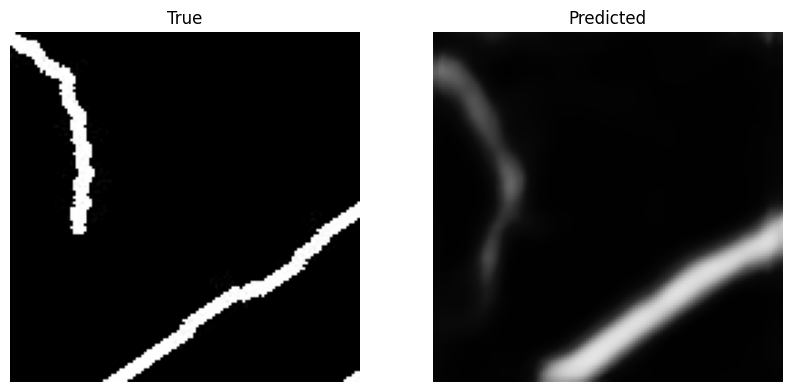

 
auc: 0.95
 
22/22 - 39s - loss: 0.3196 - accuracy: 0.8432 - jaccard: 0.4640 - dice: 0.6322 - val_loss: 0.3502 - val_accuracy: 0.8289 - val_jaccard: 0.4500 - val_dice: 0.6200 - 39s/epoch - 2s/step
Epoch 299/300

Epoch 00299: val_loss did not improve from 0.34514
22/22 - 20s - loss: 0.3149 - accuracy: 0.8449 - jaccard: 0.4645 - dice: 0.6322 - val_loss: 0.3457 - val_accuracy: 0.8302 - val_jaccard: 0.4630 - val_dice: 0.6317 - 20s/epoch - 887ms/step
Epoch 300/300

Epoch 00300: val_loss did not improve from 0.34514
22/22 - 19s - loss: 0.3085 - accuracy: 0.8454 - jaccard: 0.4733 - dice: 0.6407 - val_loss: 0.3489 - val_accuracy: 0.8307 - val_jaccard: 0.4582 - val_dice: 0.6270 - 19s/epoch - 859ms/step


In [31]:
history = model.fit(train_dataset, epochs=300, verbose=2, 
                    callbacks=[checkpointer, CustomCallback(model, train_dataset)],
                    validation_data=val_dataset)

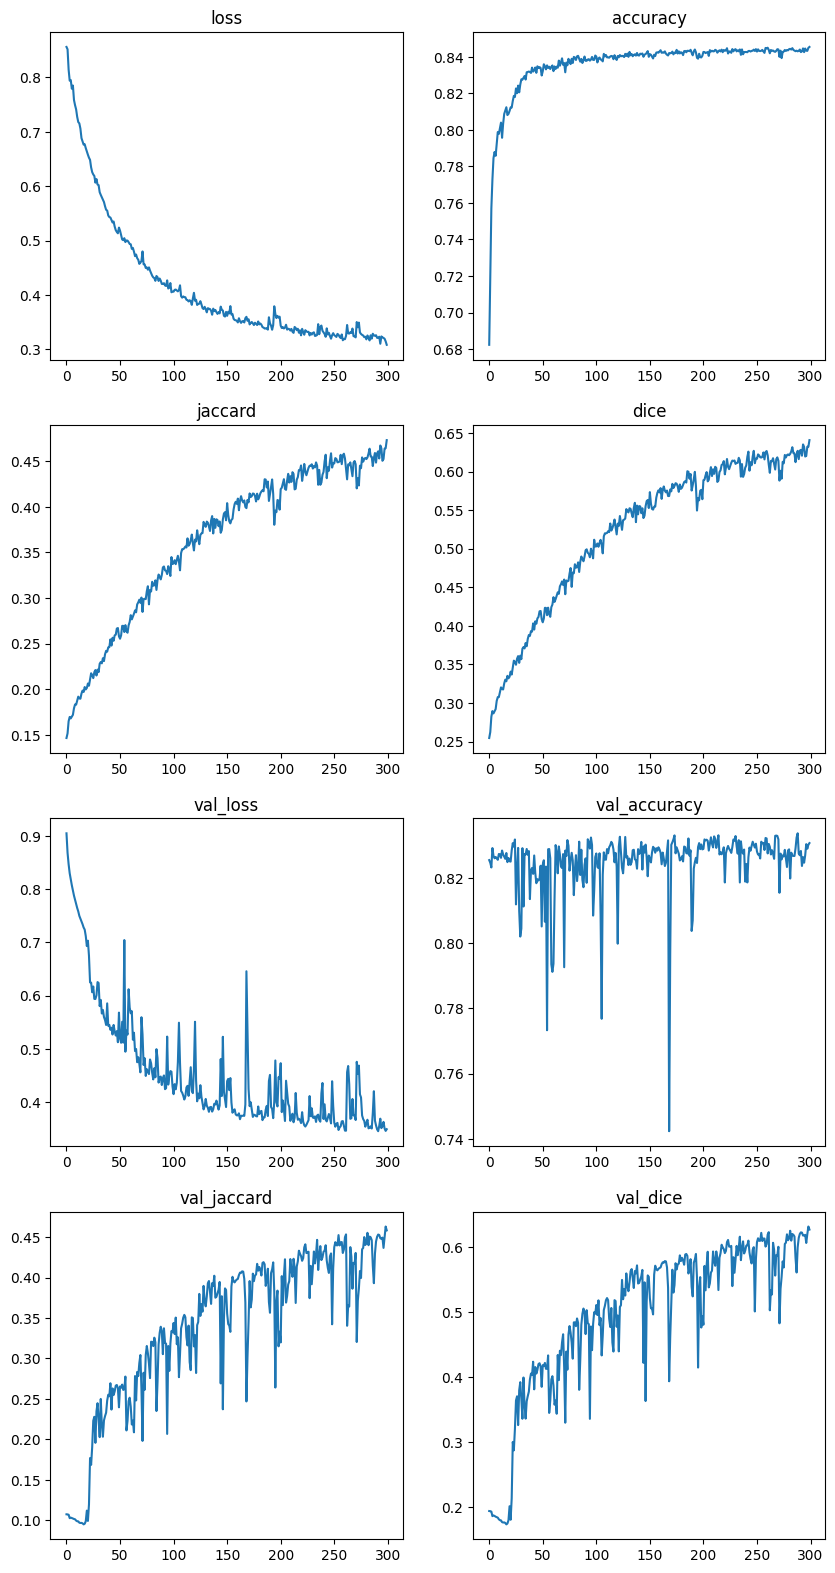

In [32]:
plt.figure(figsize=(10, 40))

for idx, key in enumerate(history.history.keys()):
    
    ax = plt.subplot(8, 2, 1 + idx)
    plt.title(key)
    plt.plot(history.history[key])

plt.show()

## Compare the results with the test images


### Get the test dataset and evaluate the model in it.

In [33]:
# The test batch size is equal to the number of pieces cut from the original
# image, this was done so that we can reconstruct the image later.

test_batch = (resize_h // crop_wh) * (width // crop_wh)

In [34]:
def parse_function_test(image, label):

    image = image[..., :3]
    image_shape = image.shape
    label_shape = label.shape

    image = tf.image.resize(image, [resize_h, width], method='nearest')
    label = tf.image.resize(label, [resize_h, width], method='nearest')

    image = tf.image.convert_image_dtype(image, tf.float32) / 255
    label = tf.image.convert_image_dtype(label, tf.float32) / 255

    image, label = crop(image, label, crop_wh, image.shape[-1])

    return image, label

In [35]:
test_file_names = [path + str(i) + '.jpg' for i in range(5, 6)]
test_labels = [path + 'bin-seg-' + str(i) + '.jpg' for i in range(5, 6)]

test_dataset = tf.data.Dataset.from_tensor_slices((test_file_names, test_labels))

test_dataset = test_dataset.map(load)
test_dataset = test_dataset.map(parse_function_test)

test_dataset = test_dataset.flat_map(
    lambda image, label: tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(image), 
    tf.data.Dataset.from_tensor_slices(label))
    ))

test_dataset = test_dataset.batch(test_batch).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [36]:
_ = model.evaluate(test_dataset)

1/1 [==============================] - 6s 6s/step - loss: 0.3528 - accuracy: 0.8653 - jaccard: 0.4002 - dice: 0.5716


### Predict and plot the segmented images

- White: Ground Truth.
- Blue: True Positive.
- Green: False Positive.

In [ ]:
# pred = model.predict(test_dataset)

In [37]:
def rebuild_image(image_cropped, label_cropped, image_pred_cropped):
    
    image = np.ones((resize_h, width, 3))
    label = np.ones((resize_h, width, 1))
    image_pred = np.ones((resize_h, width, 1))

    cont = 0

    for idx in range(0, image.shape[1] // crop_wh):
        for idy in range(0, image.shape[0] // crop_wh):
          
          image[idy * crop_wh: (idy + 1) * crop_wh, idx * crop_wh: (idx + 1) * crop_wh, :] = image_cropped[cont, ...]
          label[idy * crop_wh: (idy + 1) * crop_wh, idx * crop_wh: (idx + 1) * crop_wh, :] = label_cropped[cont, ...]
          image_pred[idy * crop_wh: (idy + 1) * crop_wh, idx * crop_wh: (idx + 1) * crop_wh, :] = image_pred_cropped[cont, ...]
          cont += 1

    return image, label, image_pred

In [38]:
def color_labels(label, image_pred):

    color_label = np.zeros((resize_h, width, 3))

    i_t, j_t = np.where(label[..., 0] > 0.1)

    # Color with white pixels where labels are equal to one.
    color_label[i_t, j_t, :] = 255
    
    i, j = np.where(image_pred[..., 0] > 0.5)
    
    label_set = set([(a, b) for a, b in zip(i_t, j_t)])
    pred_set = set([(a, b) for a, b in zip(i, j)])
    pred_tp = set(label_set).intersection(pred_set)
    
    pred_fp = pred_set - pred_tp

    k1, k2 = zip(*pred_tp)
    color_label[k1, k2, 0:2] = 0

    k1, k2 = zip(*pred_fp)
    color_label[k1, k2, 1:2] = 255

    return color_label 

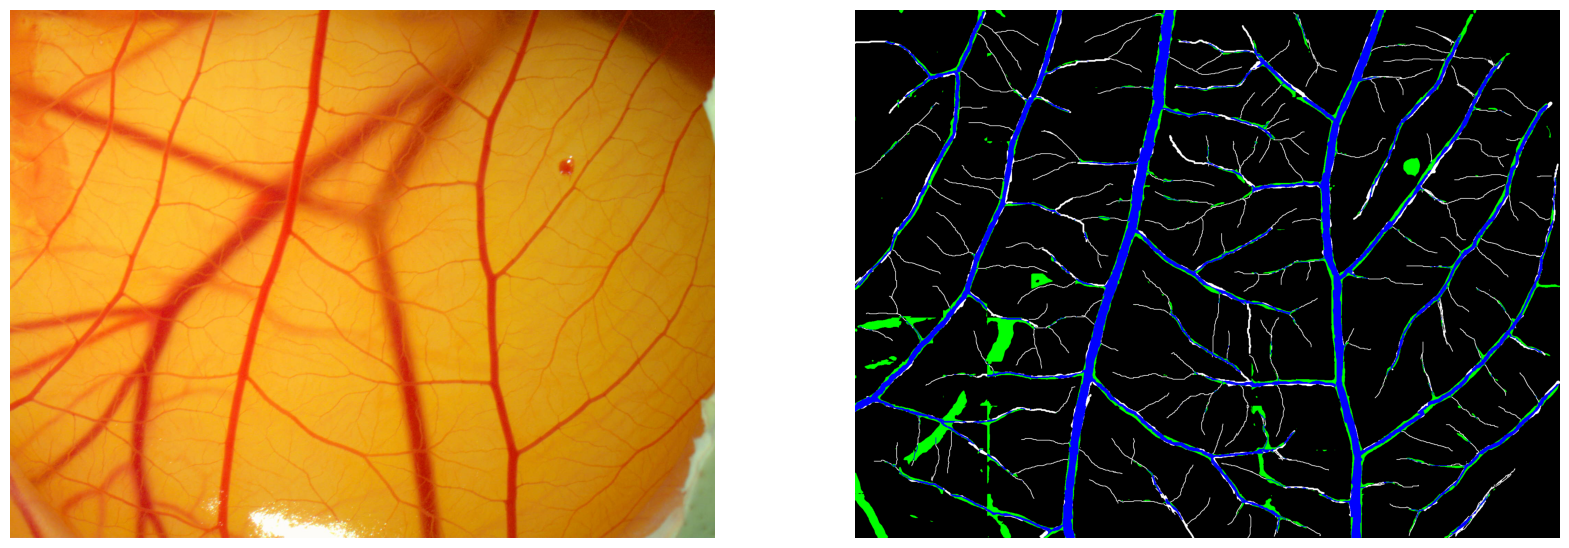

In [39]:
for data in test_dataset:
  
  image_cropped = data[0].numpy()
  label_cropped = data[1].numpy()

  image_pred_cropped = model.predict(image_cropped)

  image, label, image_pred = rebuild_image(image_cropped,
                                           label_cropped,
                                           image_pred_cropped)
  label = color_labels(label, image_pred)
  
  
  plt.figure(figsize=(20, 20))
  ax = plt.subplot(1, 2, 1)
  image = cv2.cvtColor(image.astype('float32'), cv2.IMREAD_COLOR)
 
  plt.imshow(image)
  plt.axis('off')
  
  ax = plt.subplot(1, 2, 2)
  pred_label = cv2.cvtColor(label.astype('uint8'), cv2.IMREAD_COLOR)

  plt.imshow(pred_label)
  plt.axis('off')
  plt.show()